<span style="font-size:20pt;color:blue">Sample file</span>

# import libraries and define functions
<span style="color:red">Please run this section again if you see the following message</span>
<div style="background:#fdd">
/home/yijie/.virtualenvs/jupyter-env/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
</div>

In [9]:
from __future__ import print_function
import mpld3
import os
import math
import pandas
import numpy as np
from itertools import cycle, islice

from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import to_rgb, to_hex, to_rgba

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from functools import reduce
import re
from datetime import datetime

%matplotlib notebook
# %matplotlib widget
mpld3.enable_notebook()

rcParams['figure.figsize'] = [9, 4.5]
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True

rcParams.update({'figure.autolayout': True})
rcParams.update({'axes.labelsize': 20})
rcParams.update({'xtick.labelsize': 12})
rcParams.update({'ytick.labelsize': 12})
rcParams.update({'legend.frameon': False})
rcParams.update({'legend.fontsize': 10})


# read in prodata csv file
def load_data(filename):
    # prodata sx may generate 2 formats
    # and the number of skip lines may vary
    f = open(filename)
    lines = f.readlines()
    skiprows = 0
    invert = False
    try:
        skiprows = lines.index("Time,Wavelength\n")
    except ValueError:
        try:
            skiprows = lines.index("Wavelength,Time\n")
            invert = True
        except ValueError:
            raise Exception("cannot determine number of rows to skip!")
    df = pandas.read_csv(
        filename,  # file name
        skiprows=skiprows,  # leading rows that should not be read-in
        delimiter=',',
        header=1,
        index_col=0,
        nrows=1000,
        engine='python'
    ).dropna(axis='columns', how='any')
    df.columns = df.columns.map(float)
    df.index = df.index.map(float)
    if (invert):
        df = df.T
    return df


# average over files and save
def save_average(csvfiles):   
    dfSum = reduce((lambda df1, df2: df1 + df2), list(map(load_data, csvfiles)))
    dfAve = dfSum / len(csvfiles)
    # save to file
    aveFileName = reduce((lambda s1, s2: s1 + s2),
                         re.split('.*/|-[0-9]+[.]csv', csvfiles[0])) + '-ave.csv'
    print("averaged file name is: " + aveFileName)
    aveFileName
    with open(aveFileName, 'w') as f:
        f.write('Jupyter Notebook generated file, author - Yijie Tang (yijietang@cmu.edu)\n')
        f.write('Powered by python3, matplotlib, numpy, tkinter, jupyter\n')
        f.write('File generated at ' +str(datetime.now())+ '\n')
        f.write('This is an average file, source files are: \n')
        tabbedFileNames = list(map(lambda s: '\t'+s, csvfiles))
        f.write(reduce((lambda df1, df2: df1 + '\n' + df2), tabbedFileNames))
        for i in range(4):
            f.write('\n')
        f.write('Time,Wavelength\n')
    dfAve.to_csv(float_format='%.6f', path_or_buf=aveFileName, mode='a', header=list(dfAve.columns.map(str)))


# plot all kinetic curves
def plot_all_kinetic(df, axis):
    df.plot.line(
        ax=axis,  # plot in the defined axis
        logx=True,
        xlim=(float(df.index[0]), float(df.index[-1])),
        legend=None
    )
    axis.set_xlabel("time (s)")
    axis.set_ylabel("Abs")


# plot all spectra
def plot_all_spectra(df, axis):
    df.T.plot.line(
        ax=axis,
        logx=False,
        xlim=(float(df.columns[0]), float(df.columns[-1])),
        legend=None
    )
    axis.set_xlabel("wavelength (nm)")
    axis.set_ylabel("Abs")


# select part of the df according to given values
def _get_selected_columns_as_dataframe(df, values=None, shifts=None, scales=None):
    if values is None:
        values = df.columns
    n = len(values)
    # give default values to shift and scale
    if shifts is None:
        shifts = [0] * n
    if scales is None:
        scales = [1] * n
    # build new dataframe
    dfResult = pandas.DataFrame()
    for i in range(n):
        value = values[i]
        index = abs(df.columns - value * np.ones(len(df.columns))).argmin()
        shift = shifts[i]
        scale = scales[i]
        dfResult = dfResult.append(df.iloc[:, index:index+1]*scale+shift)
    return dfResult

def select_wavelength(df, values, shifts=None, scales=None):
    return _get_selected_columns_as_dataframe(df, values=values, shifts=shifts, scales=scales)
    
def select_timepoint(df, values, shifts=None, scales=None):
    return _get_selected_columns_as_dataframe(df.T, values=values, shifts=shifts, scales=scales).T


class SFData:
    def quickload_dfs(dfs):
        colorsCycle = list(islice(cycle(['black', 'red', 'green', 'orange', 'blue']), None, len(dfs)))
        colors = [[colorsCycle[i]] for i in range(len(dfs))]
        axis = plt.figure().gca()
        legends = [[str(i+1)] for i in range(len(dfs))]
        scales = [[1] for i in range(len(dfs))]
        shifts = [[0] for i in range(len(dfs))]
        return SFData(axis, dfs, colors, legends, scales, shifts)
    
    def quickload_csv(csvfiles):
        dfs = list(map(load_data, csvfiles))
        colorsCycle = list(islice(cycle(['black', 'red', 'green', 'orange', 'blue']), None, len(dfs)))
        colors = [[colorsCycle[i]] for i in range(len(dfs))]
        axis = plt.figure().gca()
        legends = [[str(i+1)] for i in range(len(dfs))]
        scales = [[1] for i in range(len(dfs))]
        shifts = [[0] for i in range(len(dfs))]
        return SFData(axis, dfs, colors, legends, scales, shifts)

    def __init__(self, axis, dfs, colors, legends, scales, shifts, xlabel='', ylabel=''):
        self.axis = axis
        self.dfs = dfs
        self.colors = colors
        self.legends = legends
        self.scales = scales
        self.shifts = shifts
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.timepoint_master = None
        self.wavelength_master = None

    def add_logx_button(self):
        def change_logx(axis, logx):
            if logx:
                axis.set_xscale('log')
            else:
                axis.set_xscale('linear')

        button = widgets.ToggleButton(
            value=True,
            description='LogX',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Description',
            icon='check'
        )
        return interactive(change_logx, axis=fixed(self.axis), logx=button)

    def plot_selected_kinetics(self, wavelengths=None):
        if wavelengths is None:
            wavelengths = [[180] for i in range(len(self.dfs))]
        self.wavelengths = wavelengths
        self._plot_selected_value(select_wavelength, plot_all_kinetic, values=wavelengths)
        
    def plot_selected_spectra(self, timepoints=None):
        if timepoints is None:
            timepoints = [[0.001] for i in range(len(self.dfs))]
        self.timepoints = timepoints
        self._plot_selected_value(select_timepoint, plot_all_spectra, values=timepoints)

    def _plot_selected_value(self, select_function, plot_function, values=None):
        dfs = self.dfs
        shifts = self.shifts
        scales = self.scales
        axis = self.axis
        colors = self.colors
        legends = self.legends
        xlabel = self.xlabel
        ylabel = self.ylabel

        for i in range(len(self.dfs)):
            for j in range(len(values[i])):
                value = values[i][j]
                shift = shifts[i][j]
                scale = scales[i][j]
                df = select_function(dfs[i], values=[value]) * scale + shift
                plot_function(df, axis)

        index = 0
        for i in range(len(self.dfs)):
            for j in range(len(values[i])):
                line = axis.lines[index]
                if (i < len(colors) and j < len(colors[i])):
                    line.set_color(colors[i][j])
                if (i < len(legends) and j < len(legends[i])):
                    line.set_label(legends[i][j])
                index += 1

        # set labels and legends
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        handles, _ = axis.get_legend_handles_labels()
        axis.legend().set_draggable(True)
        
    def plot_interactive_buttons_for_kinetics(self):
        self.wavelength_widgets = self._plot_interactive_buttons(select_wavelength, 
                                                                 self.wavelengths, self.wavelength_master)
    def plot_interactive_buttons_for_spectra(self):
        self.timepoint_widgets = self._plot_interactive_buttons(select_timepoint,
                                                               self.timepoints, self.timepoint_master)
        
    def _plot_interactive_buttons(self, select_function, values, master_widget):
        def change_color(axis, line, color):
            line.set_color(color)
            axis.legend(loc=axis.get_legend()._loc_real).set_draggable(True)

        def change_data(axis, line, df, value, shift, scale):
            origin = select_function(df, values=[value])
            line.set_ydata(origin*scale + shift)
            axis.relim()
            axis.autoscale_view(True, True, True)

        def change_legend(axis, line, legend):
            line.set_label(legend)
            axis.legend(loc=axis.get_legend()._loc_real).set_draggable(True)

        # do not plot interactive buttons if there are too many curves
        if len(self.axis.lines) > 15:
            return

        dfs = self.dfs
        shifts = self.shifts
        scales = self.scales
        axis = self.axis
        legends = self.legends
        colors = self.colors

        index = 0
        value_widgets = []
        for i in range(len(dfs)):
            for j in range(len(values[i])):
                value = values[i][j]
                shift = shifts[i][j]
                scale = scales[i][j]
                legend = legends[i][j]
                color = colors[i][j]
                shift_widget = widgets.FloatText(
                    value=shift, step=0.01, readout_format='.2f', continuous_update=True)
                scale_widget = widgets.FloatText(
                    value=scale, readout_format='.2f', continuous_update=True)
                color_widget = widgets.ColorPicker(
                    concise=True, description=' ', value=to_hex(color), continuous_update=True)
                legend_widget = widgets.Text(
                    value=legend, placeholder='Legend')
                value_widget = widgets.FloatText(value=value, description=' ',
                                                      readout_format='.2f', continuous_update=True)
                value_widgets.append(value_widget)
                if master_widget is not None:
                    widgets.jsdlink((master_widget, 'value'), (value_widget, 'value'))
                color_widget.layout.width = '15%'
                value_widget.layout.width = '20%'
                legend_widget.layout.width = '20%'
                shift_widget.layout.width = '15%'
                scale_widget.layout.width = '15%'

                line = axis.lines[index]
                w_color = interactive(change_color, axis=fixed(
                    axis), line=fixed(line), color=color_widget)
                w_legend = interactive(change_legend, axis=fixed(
                    axis), line=fixed(line), legend=legend_widget)
                w_data = interactive(change_data, axis=fixed(axis), line=fixed(line), df=fixed(dfs[i]),
                                     shift=shift_widget, scale=scale_widget, value=value_widget)
                hbox = widgets.HBox(
                    tuple(list(w_color.children)+list(w_legend.children)+list(w_data.children)))
                display(hbox)
                index += 1
        return value_widgets

        
    def plot_scan_wavelength_button(self):
        value = abs(self.dfs[0].columns - self.wavelengths[0][0] * np.ones(len(self.dfs[0].columns))).argmin()
        length = reduce(lambda x, y: min(x, y), [len(self.dfs[i].columns) for i in range(len(self.dfs))])
        valueList = self.dfs[0].columns
        hbox = self._plot_scan_button(value, length, valueList)
        (_, self.wavelength_master) = hbox.children
        return hbox
        
    def plot_scan_timepoint_button(self):
        value = abs(self.dfs[0].T.columns - self.timepoints[0][0] * np.ones(len(self.dfs[0].T.columns))).argmin()
        length = reduce(lambda x, y: min(x, y), [len(self.dfs[i].T.columns) for i in range(len(self.dfs))])
        valueList = self.dfs[0].T.columns
        hbox = self._plot_scan_button(value, length, valueList)
        (_, self.timepoint_master) = hbox.children
        return hbox
        
    def _plot_scan_button(self, value, length, valueList):
        def change_label_text(label, index, valueList):
            label.value = valueList[index]

        dfs = self.dfs
        play = widgets.Play(
            interval=100,
            value=value,
            min=0,
            max=length-1,
            step=1,
            description="Press play",
            disabled=False
        )

        label = widgets.FloatText(description='', step=0.05, readout_format='.2f')
        w = interactive(change_label_text, label=fixed(label), index=play, valueList=fixed(valueList))
        hbox = widgets.HBox([w, label])
        self.label_master = label
        return hbox
    
def plot_from_df(df, valuetype):
#     valuetype = df.columns[-1]
    if valuetype!='timepoint' and valuetype!='wavelength':
        raise ValueError("valuetype should be either timepoint or wavelength")
    
    df = df.astype(dtype={
        'csvfile':'object',
        'legend':'object',
        'shift':'float64',
        'scale':'float64',
        'color':'object',
        valuetype:'float64',
    })
    
    def table_to_inputs(keyword):
        return df[keyword].values.reshape(len(df),1).tolist()

    rcParams['figure.figsize'] = [6, 4.5]
    fig = plt.figure()
    axis = fig.gca()

    csvfiles = df['csvfile'].values.tolist()
    dfs = list(map(load_data, csvfiles))
    values = table_to_inputs(valuetype)
    legends = table_to_inputs('legend')
    shifts = table_to_inputs('shift')
    scales = table_to_inputs('scale')
    colors = table_to_inputs('color')

    sfData = SFData(
        axis=axis,
        dfs=dfs,
        colors=colors,
        legends=legends,
        scales=scales,
        shifts=shifts,
        xlabel='Time (s)',
        ylabel='Abs',
    )
    
    if valuetype=='timepoint':
        sfData.plot_selected_spectra(values)
        # display(widgets.HBox([sfData.plot_scan_timepoint_button()]))
        sfData.plot_interactive_buttons_for_spectra()
    else:
        sfData.plot_selected_kinetics(values)
        display(sfData.add_logx_button())
        # display(widgets.HBoxsfDataData.add_logx_button(), sfData.plot_scan_wavelength_button()]))
        sfData.plot_interactive_buttons_for_kinetics()


# compare multiple inputs on selected lines

<IPython.core.display.Javascript object>


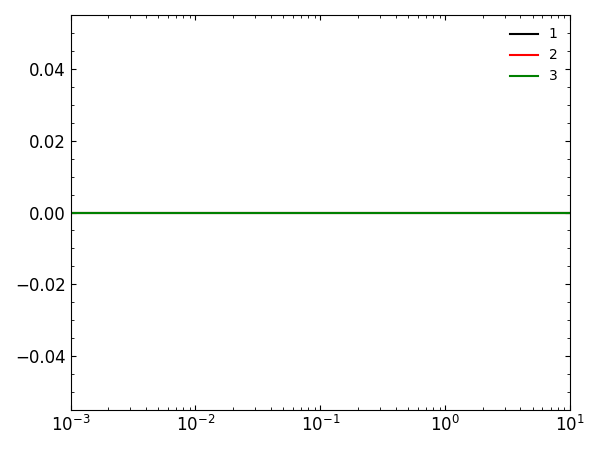

In [9]:
rcParams['figure.figsize'] = [6, 4.5]
csvfiles = [
    'average-sample-10s-1.csv',
    'average-sample-10s-2.csv',
    'average-sample-10s-3.csv',
]


sfData = SFData.quickload_csv(csvfiles)

sfData.plot_selected_kinetics()
display(widgets.HBox([sfData.add_logx_button(), sfData.plot_scan_wavelength_button()]))
sfData.plot_interactive_buttons_for_kinetics()

# save averaged files

In [10]:
csvfiles = [
    'average-sample-10s-1.csv',
    'average-sample-10s-2.csv',
    'average-sample-10s-3.csv',
]

save_average(csvfiles)

averaged file name is: average-sample-10s-ave.csv


# overview - kinetic curve and full spectra

<IPython.core.display.Javascript object>


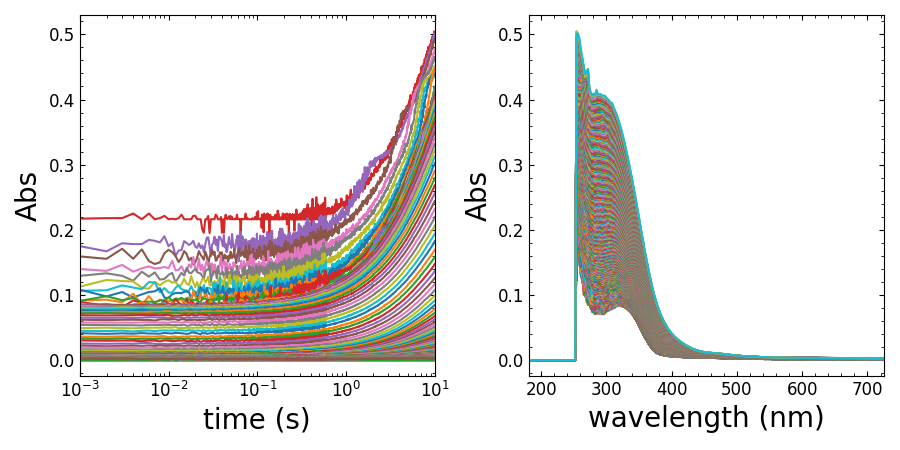

In [11]:
rcParams['figure.figsize'] = [9, 4.5]
csvfile = 'average-sample-10s-ave.csv'
df = load_data(csvfile)
(row, col) = (1, 2)
fig, axs = plt.subplots(row, col, sharex=False, sharey=False)
axis1 = axs[0]  # first axis
axis2 = axs[1]  # second axis

plot_all_kinetic(df, axis1)
plot_all_spectra(df, axis2)

# overview - difference spectra

<IPython.core.display.Javascript object>


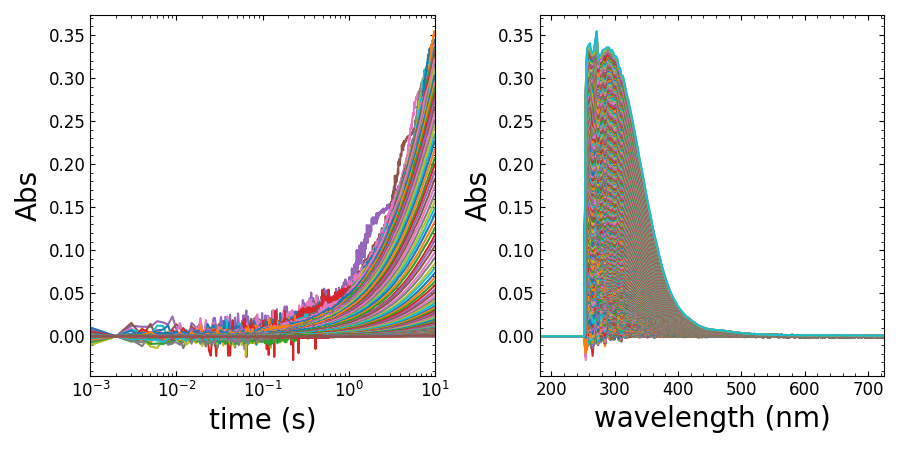

In [12]:
rcParams['figure.figsize'] = [9, 4.5]
df = load_data(csvfile)
baseCurve = df.iloc[1,:] # select the second time point as baseline
diffDf = df - baseCurve
df1 = df - baseCurve
(row, col) = (1, 2)
fig, axs = plt.subplots(row, col, sharex=False, sharey=False)
axis1 = axs[0]  # first axis
axis2 = axs[1]  # second axis

plot_all_kinetic(df1, axis1)
plot_all_spectra(df1, axis2)

# export kintek input files

In [13]:
csvfiles = [
    'kintek-sample-10s.csv'
]
wavelength = 429
dfs = list(map(load_data, csvfiles))

kintekFileName = 'kintek-sample-10s-429nm.txt'
with open(kintekFileName, 'w') as f:
    f.write('Time')
dfPartials = [_get_selected_columns_as_dataframe(df, values=[wavelength]) for df in dfs]
dfPartial = pandas.concat(dfPartials, axis=1, join='inner')
dfPartial.to_csv(sep='\t', float_format='%.6f', path_or_buf=kintekFileName, mode='a')

# plot original kinetic and kintek simulation

<IPython.core.display.Javascript object>


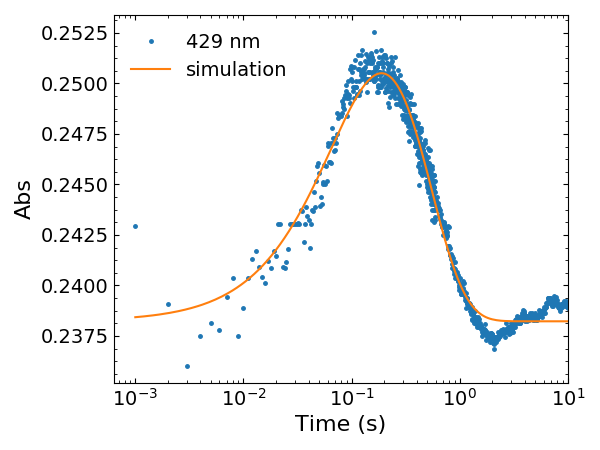

/home/yijie/.virtualenvs/jupyter-env/lib/python3.6/site-packages/pandas/plotting/_core.py:450: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(self.xlim)


In [17]:
rcParams['figure.figsize'] = [6, 4.5]
rcParams.update({'xtick.labelsize': 14})
rcParams.update({'ytick.labelsize': 14})
rcParams.update({'axes.labelsize':16})
rcParams.update({'legend.frameon': False})
rcParams.update({'legend.fontsize': 14})

kintekFileName = 'kintek-sample-10s-429nm.txt'
simFileName = 'kintek-sample-10s-429nm-sim.txt'
dfExp = pandas.read_table(
    kintekFileName,  # file name
    skiprows=0,  # leading rows that should not be read-in
    delimiter='\t',
    header=0,
    index_col=0,
#     nrows=1000,
    engine='python'
)
dfSim = pandas.read_table(
    simFileName,  # file name
    skiprows=0,  # leading rows that should not be read-in
    delimiter='\t',
    header=0,
    index_col=0,
#     nrows=1000,
    engine='python'
).dropna(axis='columns', how='any')

fig = plt.figure()
axis = fig.gca()
dfExp.plot.line(
    marker='.',
    markersize=5,
    linewidth=0,
    ax=axis,
    logx=True,
    xlim=(0,10),
    legend=None
)
dfSim.plot.line(
    ax=axis,
    logx=True,
    xlim=(0,10),
    legend=None
)

axis.set_xlabel('Time (s)')
axis.set_ylabel('Abs')
handles, labels = axis.get_legend_handles_labels()
labels = ['429 nm', 'simulation']
axis.legend(handles, labels).set_draggable(True)

# plot full spectra with more options

## plot with variables

<IPython.core.display.Javascript object>


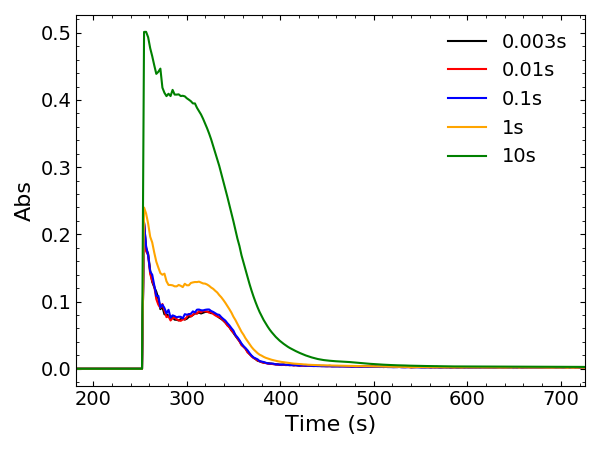

In [18]:
rcParams['figure.figsize'] = [6, 4.5]
fig = plt.figure()
axis = fig.gca()

csvfiles = [
    'average-sample-10s-ave.csv',
    'average-sample-10s-ave.csv',
    'average-sample-10s-ave.csv',
    'average-sample-10s-ave.csv',
    'average-sample-10s-ave.csv',
]

dfs = list(map(load_data, csvfiles))
# df_base = dfs[0].iloc[1,:]
# dfs = [df - df_base for df in dfs]

timepoints = [
    [0.003],
    [0.01],
    [0.1],
    [1],
    [10]
]

legends = [
    ['0.003s'],
    ['0.01s'],
    ['0.1s'],
    ['1s'],
    ['10s']
]

shifts = [
    [0],
    [0],
    [0],
    [0],
    [0]
]

scales = [
    [1],
    [1],
    [1],
    [1],
    [1],
]

colors = [
    ['black'],
    ['red'],
    ['blue'],
    ['orange'],
    ['green']
]

sfData = SFData(
    axis=axis,
    dfs=dfs,
    colors=colors,
    legends=legends,
    scales=scales,
    shifts=shifts,
    xlabel='Time (s)',
    ylabel='Abs',
)

sfData.plot_selected_spectra(timepoints)
# display(widgets.HBox([sfData.plot_scan_timepoint_button()]))
sfData.plot_interactive_buttons_for_spectra()

## plot with table

<IPython.core.display.Javascript object>


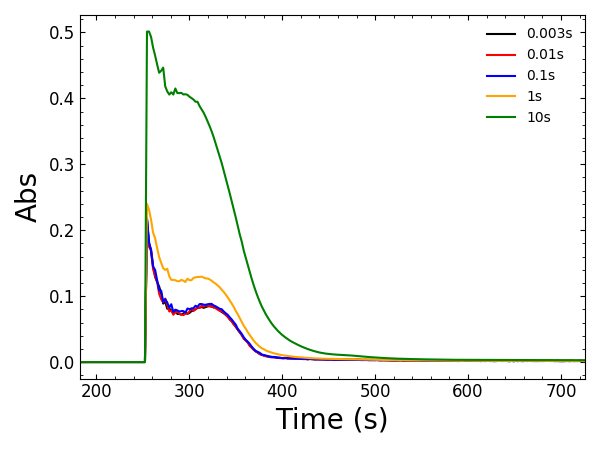

In [12]:
df = pandas.DataFrame(
    columns=['csvfile', 'legend', 'shift', 'scale', 'color', 'timepoint'],
    data=[
        ['average-sample-10s-ave.csv', '0.003s', 0, 1, 'black', 0.003],
        ['average-sample-10s-ave.csv', '0.01s', 0, 1, 'red', 0.01],
        ['average-sample-10s-ave.csv', '0.1s', 0, 1, 'blue', 0.1],
        ['average-sample-10s-ave.csv', '1s', 0, 1, 'orange', 1],
        ['average-sample-10s-ave.csv', '10s', 0, 1, 'green', 10],
    ]
)

   
plot_from_df(df, valuetype='timepoint')

# plot kinetic curves with more options

## plot with variables

<IPython.core.display.Javascript object>


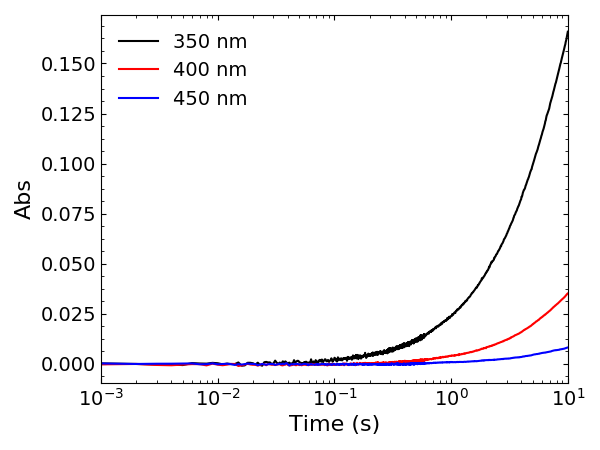

interactive(children=(ToggleButton(value=True, description='LogX', icon='check', tooltip='Description'), Outpu…

In [19]:
rcParams['figure.figsize'] = [6, 4.5]
fig = plt.figure()
axis = fig.gca()

csvfiles = [
    'average-sample-10s-ave.csv',
    'average-sample-10s-ave.csv',
    'average-sample-10s-ave.csv',
]

dfs = list(map(load_data, csvfiles))

df_base = dfs[0].iloc[1,:]
dfs = [df - df_base for df in dfs]

wavelengths = [
    [350],
    [400],
    [450],
]

legends = [
    ['350 nm'],
    ['400 nm'],
    ['450 nm'],
]

shifts = [
    [0],
    [0],
    [0],
]

scales = [
    [1],
    [1],
    [1],
]

colors = [
    ['black'],
    ['red'],
    ['blue'],
]

sfData = SFData(
    axis=axis,
    dfs=dfs,
    colors=colors,
    legends=legends,
    scales=scales,
    shifts=shifts,
    xlabel='Time (s)',
    ylabel='Abs',
)

sfData.plot_selected_kinetics(wavelengths)
display(sfData.add_logx_button())
# display(widgets.HBoxsfDataData.add_logx_button(), sfData.plot_scan_wavelength_button()]))
sfData.plot_interactive_buttons_for_kinetics()

## plot with table

<IPython.core.display.Javascript object>


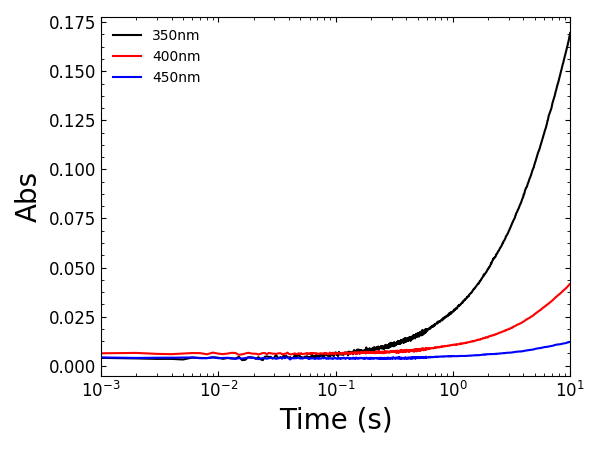

interactive(children=(ToggleButton(value=True, description='LogX', icon='check', tooltip='Description'), Outpu…

In [10]:
df = pandas.DataFrame(
    columns=['csvfile', 'legend', 'shift', 'scale', 'color', 'wavelength'],
    data=[
        ['average-sample-10s-ave.csv', '350nm', -0.05, 1, 'black', 350],
        ['average-sample-10s-ave.csv', '400nm', 0, 1, 'red', 400],
        ['average-sample-10s-ave.csv', '450nm', 0, 1, 'blue', 450],
    ]
)

   
plot_from_df(df, valuetype='wavelength')